# **Automatic License Plate Recognition**

Automatic license plate recognition (ALPR) is the extraction of vehicle license plate information from an image. The extracted information can be used in many applications such as electronic payment systems at toll plazas and parking areas. It can also be used for freeway and urban traffic surveillance.  

In this Notebook, given an image of a license plate we aim to correctly identify the registration number using Character segmentation  and Convolutional Neural Network Models (CNN). 

Our ALPR system can be split into two stages: 

*  **Character recognition**   - given an image of character classify the character 

*   **Character segmentation** - extract the alphanumeric characters from the plate  





## Initial Steps

First we import the required libraries for this project.

In [1]:
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import json
import re
from pprint import pprint
import random
import matplotlib.pyplot as plt
import seaborn as sb
import time

from PIL import Image
from PIL import ImageOps
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from google.colab.patches import cv2_imshow

torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Mounting Drive** <br></br>
If we are opening this Notebook in collab, we need to mount the drive inorder to access Dataset present in the drive folder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [3]:
%cd /content/drive/"My Drive"/CS274P

/content/drive/My Drive/CS274P


Re-confirming the path to project folder <br></br>
The project's root/main folder is '**CS274P**'.
Inside this folder we have:
1. ALPR.ipnyb notebook
2. working_org
3. LP_Dataset
4. Saved model

## Character Recongition

Since we are trying to classify captial letter Alphabets and Digits, we created a **lbls dictionary** as follows:

In [0]:
lbls = {
    0: '0', 1: '1', 2: '2', 3: '3',
    4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F',
    16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L',
    22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R',
    28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X',
    34: 'Y', 35: 'Z'
}

### Dataset and visualization 

The training and validaion data is present inside the working_org directory. Inside the working_org there are 2 folders.
Each of these folders contain individual folders for each character.
1.   **/train**
*   /0
*   /1
*   ..
*   /Z
2.   **/val**
*   /0
*   /1
*   ..
*   /Z

Next we will try to find the number of images of each character present in train and validation data.

*Accessing drive files from collab is taking time. This cell takes 2-5min to complete execution.* <br></br>
We can skip EDA and move to [Model](#scrollTo=4jAXwuGcEWMf)

In [0]:
train_hist = {}
val_hist = {}

for char in lbls:
  DIR = 'working_org/train/'+lbls[char]
  if os.path.exists(DIR):
    count = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    train_hist[lbls[char]] = count

for char in lbls:
  DIR = 'working_org/val/'+lbls[char]
  if os.path.exists(DIR):
    count = len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))])
    val_hist[lbls[char]] = count

# print(train_hist)
# print(val_hist)

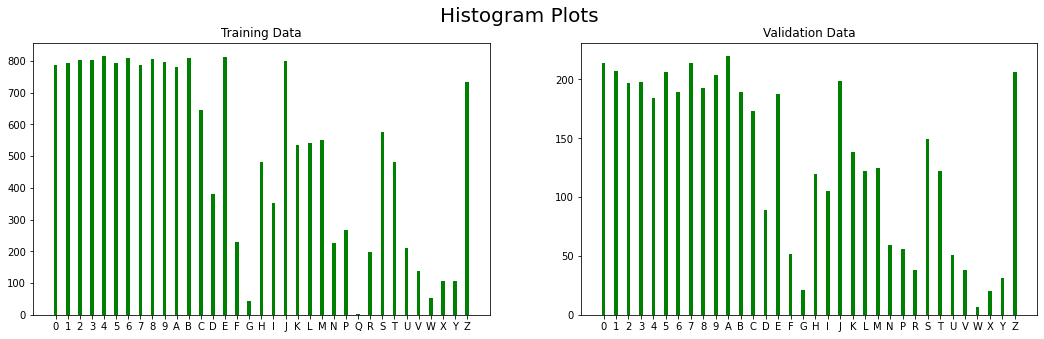

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 5)
fig.suptitle('Histogram Plots', fontsize=20)
ax[0].set_title('Training Data')
ax[0].bar(train_hist.keys(), train_hist.values(), width=0.3, color='g')
ax[1].set_title('Validation Data')
ax[1].bar(val_hist.keys(), val_hist.values(), width=0.3, color='g')
plt.show()

We see that the number of samples for characters **G, Q, W, X, Y** are less

Later we try to add more samples for those characters by Data augmentation. </br>
We rotate image by 15 degrees clockwise and anti-clockwise and added a saved copy to the dataset. </br>
But we found that data augmentation didn't increase prediction accuracy.</br>
Therefore, in our final code we have not included data augmentation though we mention the function which is used to rotate_image.


In [0]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

image = cv2.imread("working_org/val/Y/10511_2.png");
cv2_imshow(rotate_image(image, 15))

### Model

**To load the trained model please skip to [Evaluation](#scrollTo=2P_lP1N4xqj5)** 

Transfer Learning with Fixed Encoder. </br>
We have downloaded resnet101 model.

In [5]:
model = models.resnet101(pretrained=True)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Setting the output layers.

In [0]:
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features, len(lbls))

1. Loss function : **CrossEntropy loss**
2. Optimizer     : We are using **Adam optimizer** with learning rate 0.001
3. Scheduler     : Learning rate is decreased by a factor of 0.1 for every 3 epochs


In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Image is normalized and transform to tensor

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Here we load the datasets and then into data loaders. <br />
The data is shuffled before training. <br />

Upon trying different values for batch size and num workers we found our model works better when:
1. Batch size is set as 40. 
2. Num workers is also 40.



In [0]:
data_dir = 'working_org'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'val']}

In [0]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=30)
              for x in ['train', 'val']}

In [0]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
# print(class_names)
# print(dataset_sizes)

### Training

*We referred this code from Prof. Isak Bosman's CS274P week7 lecture on transfer learning.*

In [0]:
import time
def train(model, num_epochs):
    model = model.to(device)
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i = 0
            num_batches = len(dataloaders[phase])
            print("Total batches to train "+str(num_batches))
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                i = i+1
                if i%50 == 0:
                   time_elapsed = time.time() - since
                   print(str(round(i*100/len(dataloaders[phase])))+'% done in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

Let the training begin ....<br />
**Note**: The initial epoch was taking 10-15 minutes


In [0]:
train(model, num_epochs=2)

Next we are saving the trained model as **Trained_Model** in the root folder (*CS274P*)

In [38]:
torch.save(model, 'Trained_Model')
!ls

ALPR.ipynb	   LP_Dataset.zip  TransferLearning.ipynb  Working.zip
Character_Dataset  pipeline.png    Working
LP_Dataset	   Trained_Model   working_org


### Evaluation 

The trained model is saved in the root folder as 'Trained_Model'. Here we load the saved model.

In [0]:
model = torch.load('Trained_Model')
model.eval()

Helper function to preprocess an Image.

In [0]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Here we take a sample image from the validation set and see how the model is performing.

In [41]:
image = Image.open("working_org/val/Y/10511_2.png");
display(image)
image = image.convert('RGB') #We convert the image to RGB to feed it into the model
image = preprocess(image)
im = image.unsqueeze(0).to(device)
pred = model(im) #Call the trained model 
_, output = torch.max(pred, 1)
confidence = torch.nn.functional.softmax(pred, dim=1)[0] * 100
print("The model predicts it as "+str(lbls[int(output[0])+1])+" with "+str(round(confidence[output[0]].item(),2))+" confidence.")

The model predicts it as Y with 99.96 confidence.


## Character Segmentation

**License Plate Image Pre-Processing**

Given an image of the license plate, we need to extract individual characters present in it and feed it as input to the next stage in the pipeline. We will be using cv2 library to process the image and extract the characters. Before plotting contours, we perform a sequence of steps to pre-process the image. 
1. RGB to Grey  : We convert the image into grayscale format. 
2. Crop Borders :
3. Re-sizing         : Since input images might be of different size, we need to resize every image to a standard size. 
4. Blur                 : Then we blur the image to remove noise. 
5. Thresholding  : We convert the grayscale image into binary (Black white) image after sharpening if necessary. 
6. Dilation: 
7. Segmentation : Finally, we try to find contours and use bounding rectangles to segment the characters. 

In [0]:
#Sometimes segmentation results in 8 characters even though there are only 7 characters in a license plate
#In such case we can get the actual characters just by removing the first unwanted segmented image
def adjust(crop_chars):
  if len(crop_chars) == 8:
    crop_chars = crop_chars[1:]
  return crop_chars

In [0]:
def pre_process(img):
    
    #Convert to gray scale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Crop Borders
    img = img[8:img.shape[0]-8, 10:img.shape[1]-10]

    # resize image
    scale_percent = 350 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #print(img.shape)

    #Blur
    img = cv2.GaussianBlur(img,(7,7),0)

    #Thresholding
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                              cv2.THRESH_BINARY, 55, 5) 


    # Appplying dilation on the threshold image
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)) 
    dilation = cv2.dilate(thresh, rect_kernel, iterations = 1) 
    dilation = cv2.bitwise_not(dilation)
    dilation = dilation[0:dilation.shape[0], 5:dilation.shape[1]]
    img = img[0:dilation.shape[0]-0, 5:dilation.shape[1]]

    cont, _  = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    

    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = img.copy()

    # Initialize a list which will be used to append charater image
    crop_characters = []

    # define standard width and height of character
    digit_w, digit_h = 30, 70

    # Re-arrange contours from left to right
    def sort_contours(cnts,reverse = False):
        i = 0
        boundingBoxes = [cv2.boundingRect(c) for c in cnts]
        (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                            key=lambda b: b[1][i], reverse=reverse))

        return cnts

#     cv2.imshow('Threshold',thresh)    
#     cv2.imshow('Dilation',dilation)
#     cv2.imshow('Final',test_roi)
#     cv2.waitKey()
    
    i = 0
    for c in sort_contours(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        ratio = h/w
        if 0.5<=ratio<=5.5: # Only select contour with defined ratio
            if h/img.shape[0]>=0.4 and h/img.shape[0]<=0.95: # Select contour which has the height larger than 50% of the plate
                # Draw bounding box arroung digit number
                cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

                # Sperate number and gibe prediction
                curr_num = dilation[y:y+h,x:x+w]
                curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
                _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                seg = Image.fromarray(curr_num)
                crop_characters.append(seg)

                #Saving segments
#                 roi = test_roi[y:y+h, x:x+w]
#                 cv2.imwrite("char"+str(i)+".jpg", roi)
                
#                 cv2.imshow("seg"+str(i), curr_num)
                i = i+1
    return adjust(crop_characters)            

## Main

Confirming the path to project folder

In [44]:
%cd /content/drive/"My Drive"/CS274P

/content/drive/My Drive/CS274P


Extract the License plate dataset which contains the images to be tested

In [45]:
if os.path.exists('LP_Dataset'):
  print("License plate dataset already extracted")
else:
  !unzip LP_Dataset.zip

License plate dataset already extracted


**Helper function which calls the trained CNN model to recognise the segmented character**

In [0]:
def recognise(chars):
  plate = ""
  # Iterate over the array of Images and predict each Image
  for image in chars:
    image = image.convert('RGB')
    image = preprocess(image)
    im = image.unsqueeze(0).to(device)
    pred = model(im)
    _, output = torch.max(pred, 1)
    confidence = torch.nn.functional.softmax(pred, dim=1)[0] * 100
    # print(class_names[int(output[0])])
    plate = plate + lbls[int(output[0])]
    # print(confidence[output[0]].item())
  return plate

**The Main function.**
1. Given a image of license plate we first call the pre_process function to segment characters.
2. Later we pass the segmented characters to the model to predict.
3. We append the predicted values to from a string.
4. The String is then compared with the actual license-plate number to calculate the accuracy.

In [0]:
def predict(df):
    total = df.shape[0]
    segmented = 0
    recognised = 0
    for index, row in df.iterrows():
        path = "LP_Dataset/"+ row['image_path']
        X = cv2.imread(path) #License plate image
        Y = row['lp']        #License plate number
        chars = pre_process(X) #Perform segmentation
        if len(chars) == 7:
            segmented = segmented + 1
            predicted = recognise(chars) #Predict each character
            print("Actual "+Y+" Predicted "+predicted)
            if  predicted == Y:
              recognised = recognised+1
    print(str(segmented * 100/total)+" percent of lp images are correctly segmented")
    print(str(recognised * 100/segmented)+" percent of lp images are correctly recognised")
    return 

Load the LP dataset and see the properties

In [47]:
#Load the excel sheet into a data frame
df = pd.read_csv("LP_Dataset/trainVal.csv")

df = df.drop(columns=['track_id', 'train'])

print(df.head(10))
print(df.shape)

        image_path       lp
0  s01_l01/1_1.png  7C24698
1  s01_l01/2_1.png  7C24698
2  s01_l01/2_2.png  7C24698
3  s01_l01/3_1.png  5AR2347
4  s01_l01/4_1.png  5AR2347
5  s01_l01/4_2.png  5AR2347
6  s01_l01/5_1.png  4B46758
7  s01_l01/5_2.png  4B46758
8  s01_l01/6_1.png  1BA3102
9  s01_l01/6_2.png  1BA3102
(28384, 2)


We see that there are 28384 samples. </br>
Lets take a single image and see how the program is performing. </br>
*Note: It takes 30-45sec for first time.*


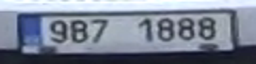

Actual license plate number is 9B71888
Predicted license plate number is 9B71888


In [48]:
index = 11 #We can change the index to check for another image
img_path = "LP_Dataset/"+df.iloc[index]['image_path']
display(Image.open(img_path).resize((256, 64)))
y = df.iloc[index]['lp']
print("Actual license plate number is "+str(y))
y_pred = recognise(pre_process(cv2.imread(img_path)))
print("Predicted license plate number is "+str(y_pred))

Now lets run the model on first 1000 images


In [51]:
predict(df.head(1000))  


Actual 7C24698 Predicted 7C24698
Actual 7C24698 Predicted 7C24698
Actual 7C24698 Predicted 7C2469R
Actual 5AR2347 Predicted 5AQ2R47
Actual 5AR2347 Predicted 5AQ2B47
Actual 4B46758 Predicted 4B46758
Actual 4B46758 Predicted A4V675K
Actual 1BA3102 Predicted 1BA3102
Actual 1BA3102 Predicted SMBAR53
Actual 9B71888 Predicted 9B71888
Actual 8U21561 Predicted 8E21561
Actual 8U21561 Predicted 8T21561
Actual 1BJ9597 Predicted 1BJ9597
Actual 0P2769F Predicted 0O2762F
Actual 0P2769F Predicted 0O2769F
Actual 7B81599 Predicted 7B81599
Actual 1BE1974 Predicted 18E1974
Actual 3B78004 Predicted 3B78005
Actual 7C02930 Predicted 7C02930
Actual 7C02930 Predicted I7D2930
Actual 7B76409 Predicted Y87E409
Actual 7B76409 Predicted 7B75409
Actual 2M71293 Predicted 2M71293
Actual 3B25276 Predicted 3B25276
Actual 3B25276 Predicted 3B25276
Actual 5AM7771 Predicted 5AM777M
Actual 5AM7771 Predicted 5AM7771
Actual 1BA9565 Predicted 1BA9565
Actual 1BA9565 Predicted 1BA9565
Actual 9B71351 Predicted 9B71351
Actual 9B7

Since, its taking long time to process we ran it for 1000 images only.

**Finally we thank you for taking time and evaluating. We learned a lot and had a lot of fun working on this project.**